<a href="https://colab.research.google.com/github/RajArPatra/Dimentionality-Reduction/blob/main/Dim_red_classifier_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [2]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import pandas as pd
import torchvision
import os
import numpy as np
from skimage import io,transform as ts
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import imgaug as ia
import imgaug.augmenters as iaa
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#from bhtsne import tsne
from torch.autograd import Variable

In [3]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

Dataset and Dataloader

In [3]:
class data1(Dataset):
    def __init__(self, train=True,device='cpu'):
      self.train=train
      self.scaler=MinMaxScaler()
      
      #self.scaler.fit(np.load('train_num.npy',allow_pickle=True)[:,-1].reshape(-1, 1))
      self.device=device
      #x_test = np.load(f,allow_pickle=True)
      #y_test= np.load('/content/y_test_pred.npy',allow_pickle=True) 
      #z=int(0.9*X_train.shape[0])
      
     
      if train:
        self.data= np.load('train_pca.npy',allow_pickle=True)
        self.data_x=self.data[:,1:]
        
        self.data_y=self.data[:,0]
      
      else:
        self.data= np.load('test_pca.npy',allow_pickle=True)
        self.data_x=self.data[:,1:]
        
        self.data_y=self.data[:,0]
      
     
      
    def __getitem__(self, idx):
     
      #X=scaler.fit_transform(X.reshape(1, -1))
      X=torch.from_numpy(self.data_x[idx]).float()
      
      
      
      '''if self.train:
        y=torch.tensor(self.map[int(self.data_y[idx])])
      else:'''
      
      y=torch.tensor(self.data_y[idx]).long()
      
     
      return X.to(self.device), y.to(self.device)
      
    def __len__(self):
      
      return self.data.shape[0]

In [4]:
if torch.cuda.is_available():
  device='cuda'
else :
   device='cpu'
device

'cuda'

In [6]:
train_dataset=data1(train=True,device=device)
test_dataset=data1(train=False,device=device)
train_loader=torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=256,
                                           shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=256, 
                                           shuffle=False)

Model Architecture

In [7]:
import torch
from torch import nn

import torch
from torch import nn
import torch.nn.functional as F


class Conv1dSamePadding(nn.Conv1d):

    def forward(self, input):
        return conv1d_same_padding(input, self.weight, self.bias, self.stride,
                                   self.dilation, self.groups)


def conv1d_same_padding(input, weight, bias, stride, dilation, groups):
    # stride and dilation are expected to be tuples.
    kernel, dilation, stride = weight.size(2), dilation[0], stride[0]
    l_out = l_in = input.size(2)
    padding = (((l_out - 1) * stride) - l_in + (dilation * (kernel - 1)) + 1)
    if padding % 2 != 0:
        input = F.pad(input, [0, 1])

    return F.conv1d(input=input, weight=weight, bias=bias, stride=stride,
                    padding=padding // 2,
                    dilation=dilation, groups=groups)


class ConvBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int,
                 stride: int) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            Conv1dSamePadding(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=stride),
            nn.BatchNorm1d(num_features=out_channels),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore

        return self.layers(x)









class ResNetBaseline(nn.Module):


    def __init__(self, in_channels: int, mid_channels: int = 64,
                 num_pred_classes: int = 1) -> None:
        super().__init__()

        # for easier saving and loading
        self.input_args = {
            'in_channels': in_channels,
            'num_pred_classes': num_pred_classes
        }

        self.layers = nn.Sequential(*[
            ResNetBlock(in_channels=in_channels, out_channels=mid_channels),
            ResNetBlock(in_channels=mid_channels, out_channels=mid_channels * 2),
            ResNetBlock(in_channels=mid_channels * 2, out_channels=mid_channels * 2),

        ])
        self.final = nn.Linear(mid_channels * 2, num_pred_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        x = self.layers(x.unsqueeze(2))
        return self.final(x.mean(dim=-1))


class ResNetBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()

        channels = [in_channels, out_channels, out_channels, out_channels]
        kernel_sizes = [8, 5, 3]

        self.layers = nn.Sequential(*[
            ConvBlock(in_channels=channels[i], out_channels=channels[i + 1],
                      kernel_size=kernel_sizes[i], stride=1) for i in range(len(kernel_sizes))
        ])

        self.match_channels = False
        if in_channels != out_channels:
            self.match_channels = True
            self.residual = nn.Sequential(*[
                Conv1dSamePadding(in_channels=in_channels, out_channels=out_channels,
                                  kernel_size=1, stride=1),
                nn.BatchNorm1d(num_features=out_channels)
            ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore

        if self.match_channels:
            return self.layers(x) + self.residual(x)
        return self.layers(x)

Helper function to Initialise weight

In [8]:
from torch.nn import init
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

In [9]:
model=ResNetBaseline(in_channels=3,num_pred_classes=2)
model=model.to(device)
init_weights(model,'kaiming')
learning_rate = 0.001
criterion1 = nn.CrossEntropyLoss()  
#optimizer1 = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9,weight_decay=0.0005,nesterov=True)  
optimizer1=torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer1, T_max=10, eta_min=0)


initialize network with kaiming


In [10]:
def accuracy_fn(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(1/ batch_size))
    return res

Save CheckPoint

In [ ]:
def save_checkpoint(model, save_folder, name, epoch, opt, best_model=False):

    if best_model:
        save_path = "{}/{}/best_model.th".format(
            save_folder, name)
    else:
        save_path = "{}/{}/epoch_{}.th".format(save_folder,
                                               name, epoch)

    if not os.path.exists(save_folder + "/" + name):
        os.makedirs(save_folder + "/" + name)

    print("SAVE MODEL to", save_path)


    param_dict = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': opt.state_dict()}

Load CheckPoint

In [11]:
def load_checkpoint(model, save_folder, model_name, opt,epoch,device ,best_model=False):
      if best_model:
        load_path = "{}/model_{}/best_model.th".format(save_folder, model_name)
      else:
        load_path = "{}/{}/epoch_{}.th".format(save_folder,
                                                model_name, epoch)

      checkpoint = torch.load(load_path)

      epoch = checkpoint['epoch']
      

      model =model # code for model init
      model.load_state_dict(checkpoint['model_state_dict'])
      model=model.to(device)

      opt =opt #code for opt init
      opt.load_state_dict(checkpoint['optimizer_state_dict'])
      #opt.param_groups[0]['lr'] = checkpoint['optimizer_params']['lr']
      return model, opt, epoch   


Train

In [ ]:
iter = 0
num_epochs=20
lst_epoch=1
for epoch in range(lst_epoch,lst_epoch+num_epochs):
    print("epoch: {}".format(epoch))
    #print('\n')
    cnt=0
    sum1=0
    correct = 0
    correct_1 = 0
    correct_3 =0
    correct_5=0
    total = 0
    model.train()
    for i, (dat,labels) in enumerate(train_loader):
        # Load images as Variable
        cnt+=1
        dat=dat.to(device)
        labels=labels.to(device)
        
        with torch.set_grad_enabled(True):
           dat = dat.requires_grad_()

           optimizer1.zero_grad()
           outputs = model(dat)
            
           loss = criterion1(outputs, labels.long())
           loss.backward()
           loss1=loss.item()
           optimizer1.step()
           _, predicted = torch.max(outputs.data, 1)
           r=accuracy_fn(outputs.data,labels.data)
           correct_1+=r[0]
           #correct_3+=r[1]
           #correct_5+=r[2]
          # Total number of labels
           total += labels.size(0)
           sum1 += loss1
          # Total correct predictions
           correct += (predicted == labels.long()).sum()
            
    
           writer.add_scalar("Loss/iter", loss1, iter)
           writer.flush()
           if(iter%1000==0):
              #pass
              print(loss1)
           

           iter += 1
    if(epoch%3==0):
      save_checkpoint(model,'/content/drive/MyDrive/Model_files','dim_reduction/classifier/pca',epoch,optimizer1)
    if(epoch%1==0):
     scheduler.step()
    accuracy = torch.true_divide(correct ,total)
    accuracy1 = torch.true_divide(correct_1 ,total).mul(labels.size(0))  
    print('Acc1:',accuracy1)
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, sum1/cnt, accuracy))
    if epoch % 1 == 0:
      cnt=0
      sum1=0
      correct_1 = 0
      correct_3 =0
      correct_5=0
      total = 0
      model.eval()
      for dat, labels in test_loader:
          dat=dat.to(device)
          labels=labels.to(device)
          cnt+=1
          
          # Load images to a Torch Variable
          dat = dat.requires_grad_()
  
          # Forward pass only to get logits/output
          outputs = model(dat)
          loss = criterion1(outputs, labels.long())
          
          loss1=loss.item()
          #print(confidence)
          #loss_l=confidence=
          
          

          # Get predictions from the maximum value
        
          
          # Total number of labels
          total += torch.tensor(1)
          sum1 += loss1
          r=accuracy_fn(outputs.data,labels.data)
          correct_1+=r[0]
          #correct_3+=r[1]
          #correct_5+=r[2]
      #print(labels.size(0))
      #a_1 = torch.true_divide(correct_1 ,total).mul(labels.size(0))  
      a_1 = torch.true_divide(correct_1 ,total)
     # a_1 = correct_1
      #a_3 = torch.true_divide(correct_3 ,total).mul(labels.size(0))  
      #a_5 = torch.true_divide(correct_5 ,total).mul(labels.size(0))  

      writer.add_scalar("Val_Loss/iter", sum1/cnt, iter)
      writer.add_scalar("accuracy_1/iter", a_1, iter)
      #writer.add_scalar("accuracy_3/iter", a_3, iter)
      #writer.add_scalar("accuracy_5/iter", a_5, iter)

      writer.flush()
      # Print Loss
      print('Iteration: {}. Val_Loss: {}.  Accuracy_1:{}'.format(iter, sum1/cnt, a_1))
      # Iterate through test dataset
      #df1=pd.read_csv('/content/merged_data/test_challenge.csv',header=0)
      '''for i, (dat, labels) in enumerate(test_loader):
        dat=dat.to(device)
        labels=labels.to(device)
        cnt+=1
        
        # Load images to a Torch Variable
        dat = dat.requires_grad_()

        # Forward pass only to get logits/output
        outputs = model(dat)
        
        #print(confidence)
        #loss_l=confidence=
        
        

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        y=get_key(predicted)
        #print(y)
        df1.loc[i, '1']=y
      df1.to_csv('output_'+str(epoch)+'.csv',index=False)
      print('output_saved')'''

epoch: 1
0.9530786275863647
0.6821597218513489
0.7197751402854919
0.6727895736694336
0.6768007874488831
0.6807894706726074
0.7015184164047241
0.6639111042022705
0.6510953307151794
0.6554569005966187
0.667686939239502
0.6685197353363037
0.6822859048843384
0.6707824468612671
0.6949492692947388
0.6960883736610413
0.6652734875679016
0.6724928617477417
0.6655018329620361
0.6609237790107727
0.6926512718200684
0.6631169319152832
Acc1: tensor(0.2148, device='cuda:0')
Epoch: 1. Loss: 0.6756204990084459. Accuracy: 0.5787991881370544
Iteration: 21485. Val_Loss: 0.6734759330810519.  Accuracy_1:0.5826969146728516
epoch: 2
0.6629194021224976
0.6755834817886353
0.6718047857284546
0.6676153540611267
0.6644377708435059
0.6691687703132629
0.6620501279830933
0.6791996955871582
0.6603966355323792
0.692258358001709
0.6984338164329529
0.6654573678970337
0.6818608641624451
0.647189199924469
0.6695906519889832
0.6713690757751465
0.6811754703521729
0.6664491891860962
0.665264904499054
0.6722822189331055
0.6850

In [14]:
model,optimizer1,lst_epoch=load_checkpoint(model,'/content/drive/MyDrive/Model_files','dim_reduction/classifier/pca',optimizer1,12,device)


Roc curve

In [31]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt

def print_roc_curve(y_test, y_score, n_classes, figsize = (8, 6)):
    lw = 2
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    fig = plt.figure(figsize=figsize)
    """
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                    ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)
    """
    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    return 

In [ ]:
def activated_output_transform(output):
    y_pred, y = output
    y_pred = torch.sigmoid(y_pred)
    return y_pred, y


In [17]:
y_test1 = []
y_score1 = []

for i, (dat,labels) in enumerate(test_loader):
        dat=dat.to(device)
        labels=labels.to(device)
        y_test1.append(labels)
        y_test = torch.cat(y_test1, dim=0)
        outputs = model(dat)
        y_score1.append(outputs)
        y_score = torch.cat(y_score1, dim=0)

In [25]:
a=y_test.detach().cpu().numpy()
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


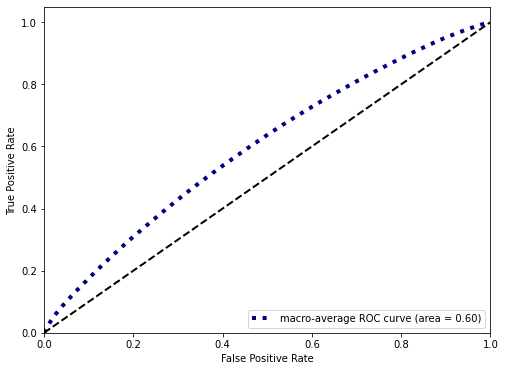

In [32]:
print_roc_curve(b ,y_score.detach().cpu().numpy(),2)